In [1]:
from nilearn import image
from nilearn.maskers import NiftiMasker
from scipy import stats
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy as np
import nibabel as nib
import pandas as pd
import os,glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load subject matrix
def load_matrix():
    data = loadmat('/Volumes/Cingulate/Sweetspot_Seg/efield_subject_matrix.mat')
    first_matrix = data['first_matrix']
    masker = NiftiMasker(mask_img='/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/binary_n-map.nii.gz', standardize=True)
    mask_nii = masker.fit()
    return mask_nii, first_matrix

#index matrix and df by cohort
def matrix_df_selection(first_matrix,df_array):
    ranges = [(0, 3), (4, 5), (6, 18), (19, 21), (22, 25), (26, 27), (28, 29), (30, 32), (32, 33), (34, 37), (38, 39), (40, 47)]
    second_matrix,df_selection = first_matrix.copy(),df_array.copy()
    
    #make cohort matricies
    cingulotomy_rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    cingulotomy_matrix = second_matrix[cingulotomy_rows]
    cap_sct_matrix = np.delete(second_matrix,cingulotomy_rows,axis=0)
    
    #make clinical outcomes cohorts
    cingulotomy_df = df_selection[cingulotomy_rows]
    cap_sct_df = np.delete(df_selection,cingulotomy_rows, axis=0)
    
    return cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df

df = pd.read_csv('/Volumes/Cingulate/Sweetspot_Seg/All_YBOCS_Vol_Cohort.csv')
df_array = df['Relative'].to_numpy().reshape(-1, 1) #change for absolute vs relative

mask_nii, first_matrix = load_matrix()
cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df = matrix_df_selection(first_matrix,df_array)

In [19]:
def sweetspot(matrix, df):
    def correlations(A, B):
        n = A.shape[1]
        dist = stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        pear_r, pear_p, spear_r, spear_p = None, None, None, None
        A[np.isnan(A)],B[np.isnan(B)] = 0,0 #make nans 0
        if corr_type == 'pearson' or corr_type == 'both':
            A_mA = A - A.mean(1)[:, None]
            B_mB = B - B.mean(1)[:, None]
            ssA = (A_mA**2).sum(1)
            ssB = (B_mB**2).sum(1)
            pear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))).ravel()
            pear_p = 2*dist.cdf(-abs(pear_r))
            pear_p = np.around(pear_p, 200)
            pear_r[np.isnan(pear_r)],pear_p[np.isnan(pear_p)] = 0,0 #replace nans with 0s
        if corr_type == 'spearman' or corr_type == 'both':
            rank_A = np.apply_along_axis(lambda x: stats.rankdata(x, method='average'), 1, A) #ranking
            rank_B = np.apply_along_axis(lambda x: stats.rankdata(x, method='average'), 1, B)
            A_mA = rank_A - rank_A.mean(1)[:, None]
            B_mB = rank_B - rank_B.mean(1)[:, None]
            ssA = (A_mA**2).sum(1)
            ssB = (B_mB**2).sum(1)
            spear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))).ravel()
            spear_p = 2 * dist.cdf(-np.abs(spear_r))
            spear_p = np.around(spear_p, 200)
            spear_r[np.isnan(spear_r)],spear_p[np.isnan(spear_p)] = 0,0 #replace nans with 0s
        return pear_r,pear_p,spear_r,spear_p
            
    def threshold(matrix,pear_r,pear_p,spear_r,spear_p):
        #n-map
        n_matrix = matrix.copy()
        n_matrix[n_matrix != 0] = 1
        binary_threshold_vector = np.sum(n_matrix, axis=0)

        #threshold n-map
        binary_threshold_vector[binary_threshold_vector <= threshold_value] = 0
        binary_threshold_vector[binary_threshold_vector > 0] = 1
        
        #threshold r & p
        if corr_type == 'pearson' or corr_type == 'both':
            sig_pearson_mask = (pear_p > 0) & (pear_p <= 0.05)
            pear_r[sig_pearson_mask == 0], pear_p[sig_pearson_mask == 0] = 0,0
            pear_r[binary_threshold_vector == 0] = 0
            pear_r[pear_r < 0] = 0 
        if corr_type == 'spearman' or corr_type == 'both':
            sig_spearman_mask = (spear_p > 0) & (spear_p <= 0.05)
            spear_r[sig_spearman_mask == 0], spear_p[sig_spearman_mask == 0] = 0,0
            spear_r[binary_threshold_vector == 0] = 0
            spear_r[spear_r < 0] = 0
        return pear_r, spear_r
    
    pear_r, spear_r = np.zeros(matrix.shape[1]), np.zeros(matrix.shape[1])  # Initialize with zeros
    threshold_value = 5 #n-threshold, greater than or equal to

    matrix = cingulotomy_matrix #cingulotomy_matrix or cap_sct_matrix
    df = cingulotomy_df #cingulotomy_df or cap_sct_df
    
    pear_r, pear_p, spear_r, spear_p = correlations(matrix.T, df.T)
    pear_r, spear_r = threshold(matrix, pear_r, pear_p, spear_r, spear_p)
    
    return pear_r, spear_r

def sweetspot_score(matrix,df_column,pear_r,spear_r):
    pearson_score,spearman_score = np.zeros((matrix.shape[0])),np.zeros((matrix.shape[0]))
    
    if corr_type == 'pearson' or corr_type == 'both':
        for i in range(matrix.shape[0]):
            pearson_score[i] = np.mean(np.multiply(pear_r[matrix[i, :] != 0], matrix[i, matrix[i, :] != 0]))
    ppr, ppp = pearsonr(pearson_score, df_column)  
    spr, spp = spearmanr(pearson_score, df_column) 
            
    if corr_type == 'spearman' or corr_type == 'both':
        for i in range(matrix.shape[0]):
            spearman_score[i] = np.mean(np.multiply(spear_r[matrix[i, :] != 0], matrix[i, matrix[i, :] != 0]))
    psr, psp = pearsonr(spearman_score, df_column)  
    ssr, ssp = spearmanr(spearman_score, df_column)
    
    return pearson_score,spearman_score,ppr,ppp,spr,spp,psr,psp,ssr,ssp

matrix = cingulotomy_matrix
df = cingulotomy_df

def cross_validations(matrix,df):
    num_sub = matrix.shape[0]
    for i in range(num_sub):
        print(f'Iteration: {i + 1}/{num_sub}')
        current_subject_matrix = np.delete(matrix, i, axis=0) #exclude the i-th subject
        current_clinical_outcomes = np.delete(df, i, axis=0) #exclude i-th subject's clinical outcomes
        pear_r,spear_r = sweetspot(current_subject_matrix,current_clinical_outcomes)
        pearson_score,spearman_score,ppr,ppp,spr,spp,psr,psp,ssr,ssp = sweetspot_score(matrix,df_column,pear_r,spear_r)
    return pearson_score,spearman_score,ppr,ppp,spr,spp,psr,psp,ssr,ssp
        
matrix = cingulotomy_matrix #cingulotomy_matrix or cap_sct_matrix

df_column = cingulotomy_df.flatten()
corr_type = 'both' #change for pearson or spearman

pear_r, spear_r = sweetspot(matrix,df)
pearson_score,spearman_score,ppr,ppp,spr,spp,psr,psp,ssr,ssp = sweetspot_score(matrix,df_column,pear_r,spear_r)
pearson_score,spearman_score,ppr,ppp,spr,spp,psr,psp,ssr,ssp = cross_validations(matrix,df)

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_11599/1909505249.py:12: RuntimeWarning: invalid value encountered in divide
  pear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))).ravel()
/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_11599/1909505249.py:23: RuntimeWarning: invalid value encountered in divide
  spear_r = (np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))).ravel()


Iteration: 1/37
Iteration: 2/37
Iteration: 3/37
Iteration: 4/37
Iteration: 5/37
Iteration: 6/37
Iteration: 7/37
Iteration: 8/37
Iteration: 9/37
Iteration: 10/37
Iteration: 11/37
Iteration: 12/37
Iteration: 13/37
Iteration: 14/37
Iteration: 15/37
Iteration: 16/37
Iteration: 17/37
Iteration: 18/37
Iteration: 19/37
Iteration: 20/37
Iteration: 21/37
Iteration: 22/37
Iteration: 23/37
Iteration: 24/37
Iteration: 25/37
Iteration: 26/37
Iteration: 27/37
Iteration: 28/37
Iteration: 29/37
Iteration: 30/37
Iteration: 31/37
Iteration: 32/37
Iteration: 33/37
Iteration: 34/37
Iteration: 35/37
Iteration: 36/37
Iteration: 37/37


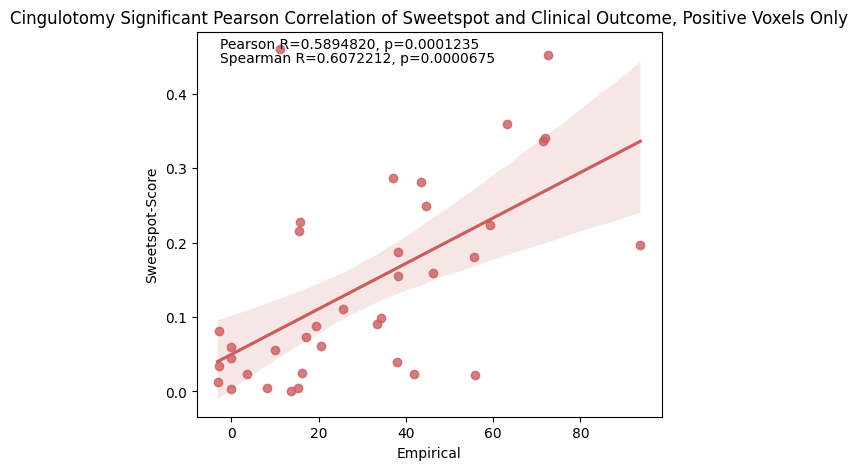

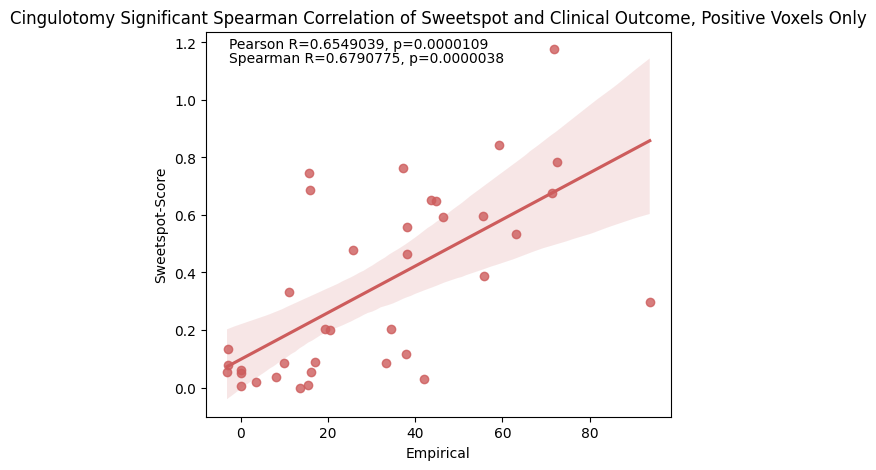

In [20]:
#cingulotomies, relative
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

#pearson analysis
plot_analysis(cingulotomy_df, pearson_score, 'Cingulotomy Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', ppr, ppp, spr, spp, 'indianred')
plot_analysis(cingulotomy_df, spearman_score, 'Cingulotomy Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', psr, psp, ssr, ssp, 'indianred')

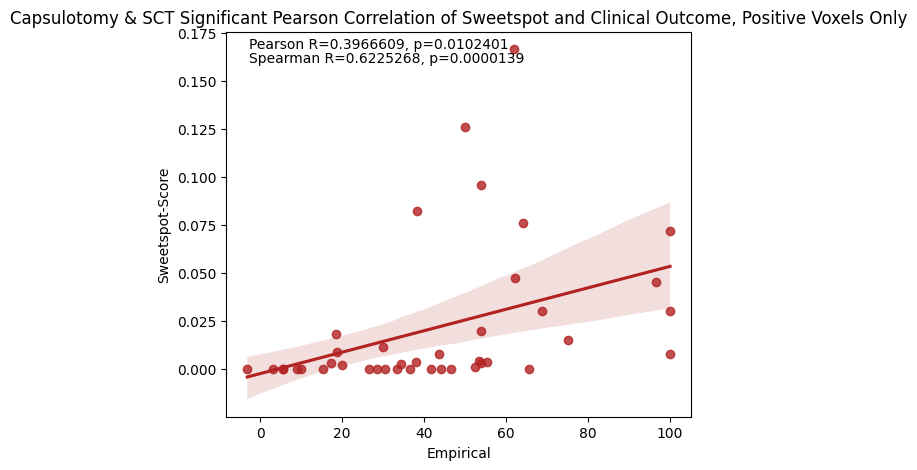

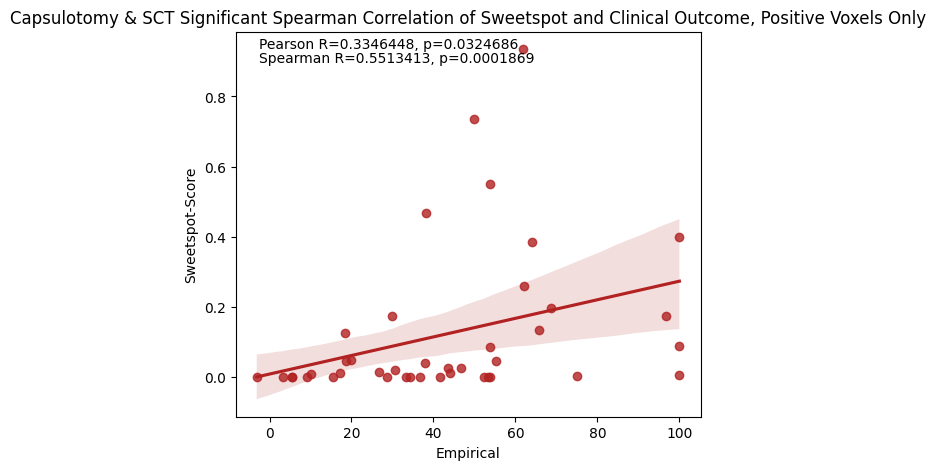

In [18]:
#capsulotomies and scts, relative
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.show()

#pearson analysis
plot_analysis(cap_sct_df, pearson_score, 'Capsulotomy & SCT Significant Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', ppr, ppp, spr, spp, 'firebrick')
plot_analysis(cap_sct_df, spearman_score, 'Capsulotomy & SCT Significant Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only', psr, psp, ssr, ssp, 'firebrick')